In [1]:
import aocd
import re
import networkx as nx

from dataclasses import dataclass
from itertools import repeat
from more_itertools import distribute, interleave
from functools import cache

In [2]:
@dataclass
class Valve:
    name: str
    flow_rate: int
    neighbors: list[str]

def parse_valve(line: str) -> Valve:
    m = re.match(r'Valve (.+) has flow rate=(.+); tunnels? leads? to valves? (.+)', line)
    return Valve(name=m[1], flow_rate=int(m[2]), neighbors=m[3].split(', '))

valves = [parse_valve(line) for line in aocd.get_data(day=16, year=2022).splitlines()]
flow_rates = sorted([v.flow_rate for v in valves], reverse=True)

In [3]:
G = nx.Graph()

for v in valves:
    G.add_node(v.name, flow_rate=v.flow_rate)
    G.add_edges_from((v.name, neighbor) for neighbor in v.neighbors)

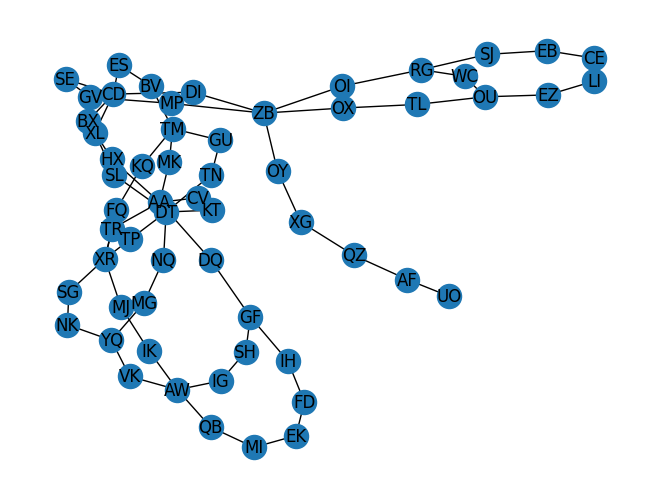

In [4]:
nx.draw(G, with_labels=True)

In [5]:
max_pressure_released = 0

@cache
def best_case_heuristic(minutes_left, valves_left):
    minutes = reversed(range(minutes_left))
    valves  = interleave(valves_left, repeat(0), repeat(0))
    return sum(m * v for m, v in zip(minutes, valves))

def making_my_way(from_node: str, minutes_left: int, steps: list[str], pressure_released: int, valves_left: list[int]):
    global max_pressure_released
    assert minutes_left >= 0

    if not minutes_left:
        if pressure_released > max_pressure_released:
            max_pressure_released = pressure_released
            # print(pressure_released, steps + [from_node])
        return
    
    if pressure_released + best_case_heuristic(minutes_left, tuple(valves_left)) < max_pressure_released:
        return

    for neighbor in G[from_node]:
        if not steps or neighbor != steps[-1]:
            making_my_way(neighbor, minutes_left-1, steps+[from_node], pressure_released, valves_left)
    
    flow_rate = G.nodes[from_node]['flow_rate']
    if f'open {from_node}' not in steps and flow_rate:
        
        minutes_left -= 1
        pressure_released += minutes_left * flow_rate
        steps = steps + [f'open {from_node}']
        valves_left = valves_left.copy()
        valves_left.remove(flow_rate)
    
        if minutes_left:
            for neighbor in G[from_node]:
                making_my_way(neighbor, minutes_left-1, steps+[from_node], pressure_released, valves_left)
        else:
            if pressure_released > max_pressure_released:
                max_pressure_released = pressure_released
                # print(pressure_released, steps + [from_node])
            

making_my_way('AA', 30, [], 0, flow_rates)
max_pressure_released

1595

In [6]:
max_pressure_released = 0

@cache
def best_case_heuristic(minutes_left, valves_left):
    minutes = reversed(range(minutes_left))
    valves1, valves2 = distribute(2, list((valves_left)) + [0])
    return sum(m * (v1+v2) for m, v1, v2 in zip(minutes, interleave(valves1, repeat(0), repeat(0)), interleave(valves2, repeat(0), repeat(0))))

def making_our_way(node1: str, node2: str, minutes_left: int, steps1: list[str], steps2: list[str], pressure_released: int, valves_left: list[int]):
    global max_pressure_released
    assert minutes_left >= 0

    if not minutes_left:
        if pressure_released > max_pressure_released:
            max_pressure_released = pressure_released
            # print(pressure_released, steps1 + [node1], steps2 + [node2])
        return
    
    if len(steps1) > 1 and steps1[-2] == node1:
        return
    if len(steps2) > 1 and steps2[-2] == node2:
        return
    if pressure_released + best_case_heuristic(minutes_left, tuple(valves_left)) < max_pressure_released:
        return
    
    minutes_left -= 1
    flow_rate1 = G.nodes[node1]['flow_rate']
    flow_rate2 = G.nodes[node2]['flow_rate']
    valve1 = f'open {node1}'
    valve2 = f'open {node2}'

    for open1 in [False, True]:
        for open2 in [False, True]:
            match open1, open2:
                case False, False:
                    for neighbor1 in G[node1]:
                        for neighbor2 in G[node2]:
                            if node1 != node2 or neighbor1 != neighbor2:
                                making_our_way(neighbor1, neighbor2, minutes_left, steps1 + [node1], steps2 + [node2], pressure_released, valves_left)
                case True, False:
                    if valve1 not in steps1 and valve1 not in steps2 and flow_rate1:
                        vl = valves_left[:]
                        vl.remove(flow_rate1)
                        for neighbor2 in G[node2]:
                            making_our_way(node1, neighbor2, minutes_left, steps1 + [f'open {node1}'], steps2 + [node2], pressure_released + minutes_left * flow_rate1, vl)
                case False, True:
                    if valve2 not in steps1 and valve2 not in steps2 and flow_rate2:
                        vl = valves_left[:]
                        vl.remove(flow_rate2)
                        for neighbor1 in G[node1]:
                            making_our_way(neighbor1, node2, minutes_left, steps1 + [node1], steps2 + [f'open {node2}'], pressure_released + minutes_left * flow_rate2, vl)
                case True, True:
                    if node1 != node2 and valve1 not in steps1 and valve1 not in steps2 and flow_rate1 and valve2 not in steps1 and valve2 not in steps2 and flow_rate2:
                        vl = valves_left[:]
                        vl.remove(flow_rate1)
                        vl.remove(flow_rate2)
                        making_our_way(node1, node2, minutes_left, steps1 + [f'open {node1}'], steps2 + [f'open {node2}'], pressure_released + minutes_left * (flow_rate1 + flow_rate2), vl)

making_our_way('AA', 'AA', 26, [], [], 0, flow_rates)
max_pressure_released

2189